In [1]:
#from google.colab import files, drive
#drive.mount('/content/drive')

In [2]:
#!pip install -r ./drive/MyDrive/CMC/requirements.txt

In [3]:
'''
from __future__ import absolute_import

import sys
import os

sys.path.append('./drive/My Drive/CMC/')
'''

"\nfrom __future__ import absolute_import\n\nimport sys\nimport os\n\nsys.path.append('./drive/My Drive/CMC/')\n"

In [4]:
#!wandb login

In [1]:
from __future__ import absolute_import

import sys
import os

import shutil

try:
    from dotenv import find_dotenv, load_dotenv
except:
    pass

import argparse

try:
    sys.path.append(os.path.join(os.path.dirname(__file__), './drive/My Drive/CMC/'))
except:
    sys.path.append(os.path.join(os.getcwd(), './drive/My Drive/CMC/'))
    
try:
    sys.path.append(os.path.join(os.path.dirname(__file__), '../'))
except:
    sys.path.append(os.path.join(os.getcwd(), '../'))
    
import pandas as pd
import numpy as np

import pickle
from collections import Counter
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

try:
    import wandb
    load_dotenv(find_dotenv())
    wandb.login(key=os.environ['WANDB_API_KEY'])
    from wandb.keras import WandbCallback
    _has_wandb = True
except:
    _has_wandb = False

import tokenizers
from transformers import TFAutoModel, AutoTokenizer, AutoConfig, BertTokenizer

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from src import data, models

pd.options.display.max_colwidth = -1

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: WARNING Calling wandb.login() without arguments from jupyter should prompt you for an api key.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/victor/.netrc
/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
print (_has_wandb)

True


In [3]:
parser = argparse.ArgumentParser(prog='Trainer',conflict_handler='resolve')

#parser.add_argument('--train_data', type=str, default='./drive/My Drive/CMC/data/IIITH_Codemixed.txt', required=False,
#                    help='train data')
parser.add_argument('--train_data', type=str, default='../data/raw/Hate-speech-dataset/hate_speech.tsv', required=False,
                    help='train data')
parser.add_argument('--val_data', type=str, default=None, required=False,
                    help='validation data')
parser.add_argument('--test_data', type=str, default=None, required=False,
                    help='test data')

parser.add_argument('--transformer_model_pretrained_path', type=str, default='roberta-base', required=False,
                    help='transformer model pretrained path or huggingface model name')
parser.add_argument('--transformer_config_path', type=str, default='roberta-base', required=False,
                    help='transformer config file path or huggingface model name')
parser.add_argument('--transformer_tokenizer_path', type=str, default='roberta-base', required=False,
                    help='transformer tokenizer file path or huggingface model name')

parser.add_argument('--max_text_len', type=int, default=50, required=False,
                    help='maximum length of text')
parser.add_argument('--max_char_len', type=int, default=200, required=False,
                    help='maximum length of text')
parser.add_argument('--max_word_char_len', type=int, default=20, required=False,
                    help='maximum length of text')

parser.add_argument('--emb_dim', type=int, default=128, required=False,
                    help='maximum length of text')
parser.add_argument('--n_layers', type=int, default=2, required=False,
                    help='maximum length of text')
parser.add_argument('--n_units', type=int, default=128, required=False,
                    help='maximum length of text')

parser.add_argument('--epochs', type=int, default=500, required=False,
                    help='number of epochs')
parser.add_argument('--lr', type=float, default=.001, required=False,
                    help='learning rate')
parser.add_argument('--early_stopping_rounds', type=int, default=50, required=False,
                    help='number of epochs for early stopping')
parser.add_argument('--lr_schedule_round', type=int, default=30, required=False,
                    help='number of epochs for learning rate scheduling')

parser.add_argument('--train_batch_size', type=int, default=8, required=False,
                    help='train batch size')
parser.add_argument('--eval_batch_size', type=int, default=8, required=False,
                    help='eval batch size')

#parser.add_argument('--model_save_path', type=str, default='./drive/My Drive/CMC/models/model_hindi_sentiment/', required=False,
#                    help='seed')

parser.add_argument('--model_save_path', type=str, default='../models/hate_detection/', required=False,
                    help='seed')

parser.add_argument('--wandb_logging', type=bool, default=True, required=False,
                    help='wandb logging needed')

parser.add_argument('--seed', type=int, default=42, required=False,
                    help='seed')


args, _ = parser.parse_known_args()

In [4]:
tf.random.set_seed(args.seed)
np.random.seed(args.seed)

In [5]:
df = pd.read_csv(args.train_data, sep='\t',header=None,usecols=[0,1])
df.columns = ['text','category']
df = df.dropna()
df = df[df.text != '']

kf = KFold(n_splits=5, shuffle=True, random_state=args.seed)
for train_index, test_index in kf.split(df.text):
    break

train_df = df.iloc[train_index]
kf2 = KFold(n_splits=2, shuffle=True, random_state=args.seed)
for val_index, test_index in kf2.split(df.iloc[test_index].text):
    break

val_df = df.iloc[val_index]
test_df = df.iloc[test_index]

I0304 19:45:52.034264 4726722048 utils.py:141] NumExpr defaulting to 4 threads.


In [6]:
print (train_df.shape, val_df.shape, test_df.shape)

(3662, 2) (458, 2) (458, 2)


In [7]:
train_df.head(5)

,text,category
0,"Knowing ki Vikas kitna samjhata hai Priyanka aur Itch Guard Luv ko, usne bola tha Ben wali baat me ab Sallu ne bhi agree kiya!",no
1,I am Muhajir .. Aur mere lye sab se Pehly Pakistan he .. agr 10 lakh Altaf Jese leaders bh is zameen ki behurmati kren un sbko sar e aam phansi Deni chahye .. Proud to be a #Muhajir and #Pakistani,no
2,"Doctor sab sahi me ke PhD (in hate politics) wale. Bhai padhe likhe ho fir kyu ye sab baate karte ho. Tum bas bowling khelo, aur maje lo. pic.twitter.com/fk1qUbQstw",no
3,"Poore Desh me Patel OBC me aate Hain sirf gujrat Ko chor kar may be, ye manuwadiyon bramanwadi kabhi aapko aarackchan nahi denge ye to jis OBC Ko Mila hai usse bhi nafrat karte hain ye khoon aur chamdi ka frak karne waale bharmhanwadi kisi ke sage nahi hain",no
4,"Sarkar banne ke bad Hindu hit me ek bhi faisla Jo bjp ke dwara liya gaya ho,bjp ko gay,gobar,mandir,masjid aur nafrat faila kar vot chahiye",yes


In [8]:
train_df.text = train_df.text.apply(lambda x: data.preprocessing.clean_tweets(x))
val_df.text = val_df.text.apply(lambda x: data.preprocessing.clean_tweets(x))
test_df.text = test_df.text.apply(lambda x: data.preprocessing.clean_tweets(x))

/Users/victor/.local/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [9]:
train_df = train_df[train_df.text != '']
val_df = val_df[val_df.text != '']
test_df = test_df[test_df.text != '']


In [10]:
train_df.text.apply(lambda x: len(x)).describe()

count    3661.000000
mean     102.369571 
std      53.175251  
min      6.000000   
25%      63.000000  
50%      99.000000  
75%      130.000000 
max      313.000000 
Name: text, dtype: float64

In [11]:
train_df.text.apply(lambda x: len(x.split())).describe()

count    3661.000000
mean     19.663207  
std      10.279373  
min      1.000000   
25%      12.000000  
50%      19.000000  
75%      25.000000  
max      64.000000  
Name: text, dtype: float64

In [12]:
model_save_dir = args.model_save_path

try:
    os.makedirs(model_save_dir)
except OSError:
    pass

In [13]:
train_df.category.value_counts()

no     2316
yes    1342
on     2   
n      1   
Name: category, dtype: int64

In [14]:
train_df = train_df[train_df.category.str.contains('yes|no')]
val_df = val_df[val_df.category.str.contains('yes|no')]
test_df = test_df[test_df.category.str.contains('yes|no')]


In [15]:
model_save_dir

'../models/hate_detection/'

In [16]:
train_df.category, label2idx = data.data_utils.convert_categorical_label_to_int(train_df.category.values, \
                                                         save_path=os.path.join(model_save_dir,'label2idx.pkl'))

val_df.category, _ = data.data_utils.convert_categorical_label_to_int(val_df.category.values, \
                                                         save_path=os.path.join(model_save_dir,'label2idx.pkl'))

test_df.category, _ = data.data_utils.convert_categorical_label_to_int(test_df.category.values, \
                                                         save_path=os.path.join(model_save_dir,'label2idx.pkl'))

In [17]:
train_df.head(5)

,text,category
0,"knowing ki vikas kitna samjhata hai priyanka aur itch guard luv ko, usne bola tha ben wali baat me ab sallu ne bhi agree kiya!",0
1,i am muhajir .. aur mere lye sab se pehly pakistan he .. agr lakh altaf jese leaders bh is zameen ki behurmati kren un sbko sar e aam phansi deni chahye .. proud to be a and,0
2,"doctor sab sahi me ke phd (in hate politics) wale. bhai padhe likhe ho fir kyu ye sab baate karte ho. tum bas bowling khelo, aur maje lo. pic.twitter.com/fkqubqstw",0
3,"poore desh me patel obc me aate hain sirf gujrat ko chor kar may be, ye manuwadiyon bramanwadi kabhi aapko aarackchan nahi denge ye to jis obc ko mila hai usse bhi nafrat karte hain ye khoon aur chamdi ka frak karne waale bharmhanwadi kisi ke sage nahi hain",0
4,"sarkar banne ke bad hindu hit me ek bhi faisla jo bjp ke dwara liya gaya ho,bjp ko gay,gobar,mandir,masjid aur nafrat faila kar vot chahiye",1


In [18]:
print (label2idx)

{'no': 0, 'yes': 1}


In [19]:
idx2label = {i:w for (w,i) in label2idx.items()}

### Learn tokenizer

In [20]:
#data.custom_tokenizers.custom_wp_tokenizer(train_df.text.values, args.model_save_path, args.model_save_path)
tokenizer = BertTokenizer.from_pretrained(args.model_save_path)

In [21]:
word_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=50000, split=' ',oov_token=1)
char_tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True, split='',oov_token=1)

word_tokenizer.fit_on_texts(train_df.text.values)
char_tokenizer.fit_on_texts(train_df.text.values)

In [22]:
transformer_train_inputs, _, _ = data.data_utils.compute_transformer_input_arrays(train_df, 'text', tokenizer, args.max_char_len)

word_train_inputs = word_tokenizer.texts_to_sequences(train_df.text.values)
word_train_inputs = tf.keras.preprocessing.sequence.pad_sequences(word_train_inputs, maxlen=args.max_text_len)

subword_train_inputs = np.asarray([data.data_utils.subword_tokenization(text, char_tokenizer, args.max_text_len, args.max_word_char_len) \
                        for text in tqdm(train_df.text.values)])

char_train_inputs = char_tokenizer.texts_to_sequences(train_df.text.values)
char_train_inputs = tf.keras.preprocessing.sequence.pad_sequences(char_train_inputs, maxlen=args.max_char_len)

train_outputs = data.data_utils.compute_output_arrays(train_df, 'category')

transformer_val_inputs, _, _ = data.data_utils.compute_transformer_input_arrays(val_df, 'text', tokenizer, args.max_char_len)

word_val_inputs = word_tokenizer.texts_to_sequences(val_df.text.values)
word_val_inputs = tf.keras.preprocessing.sequence.pad_sequences(word_val_inputs, maxlen=args.max_text_len)

subword_val_inputs = np.asarray([data.data_utils.subword_tokenization(text, char_tokenizer, args.max_text_len, args.max_word_char_len) \
                        for text in tqdm(val_df.text.values)])

char_val_inputs = char_tokenizer.texts_to_sequences(val_df.text.values)
char_val_inputs = tf.keras.preprocessing.sequence.pad_sequences(char_val_inputs, maxlen=args.max_char_len)

val_outputs = data.data_utils.compute_output_arrays(val_df, 'category')

transformer_test_inputs, _, _ = data.data_utils.compute_transformer_input_arrays(test_df, 'text', tokenizer, args.max_char_len)

word_test_inputs = word_tokenizer.texts_to_sequences(test_df.text.values)
word_test_inputs = tf.keras.preprocessing.sequence.pad_sequences(word_test_inputs, maxlen=args.max_text_len)

subword_test_inputs = np.asarray([data.data_utils.subword_tokenization(text, char_tokenizer, args.max_text_len, args.max_word_char_len) \
                        for text in tqdm(test_df.text.values)])

char_test_inputs = char_tokenizer.texts_to_sequences(test_df.text.values)
char_test_inputs = tf.keras.preprocessing.sequence.pad_sequences(char_test_inputs, maxlen=args.max_char_len)

test_outputs = data.data_utils.compute_output_arrays(test_df, 'category')

train_outputs = tf.keras.utils.to_categorical(train_outputs, \
                                                    num_classes=train_df.category.nunique())
val_outputs = tf.keras.utils.to_categorical(val_outputs, \
                                                    num_classes=train_df.category.nunique())
test_outputs = tf.keras.utils.to_categorical(test_outputs, \
                                                    num_classes=train_df.category.nunique())

tfidf1 = TfidfVectorizer(stop_words='english',ngram_range=(1,3), max_df=.6,min_df=2)
tfidf2 = TfidfVectorizer(analyzer='char_wb',ngram_range=(1,3), max_df=.6,min_df=2)

tfidf1.fit(train_df.text)
tfidf2.fit(train_df.text)

train_tfidf = np.hstack([tfidf1.transform(train_df.text).toarray(),tfidf2.transform(train_df.text).toarray()])
val_tfidf = np.hstack([tfidf1.transform(val_df.text).toarray(),tfidf2.transform(val_df.text).toarray()])
test_tfidf = np.hstack([tfidf1.transform(test_df.text).toarray(),tfidf2.transform(test_df.text).toarray()])


print (transformer_train_inputs.shape, subword_train_inputs.shape, word_train_inputs.shape, char_train_inputs.shape, \
       train_tfidf.shape, train_outputs.shape)
print (transformer_val_inputs.shape, subword_val_inputs.shape, word_val_inputs.shape, char_val_inputs.shape, \
       val_tfidf.shape, val_outputs.shape)
print (transformer_test_inputs.shape, subword_test_inputs.shape, word_test_inputs.shape, char_test_inputs.shape, \
       test_tfidf.shape, test_outputs.shape)


100%|██████████| 458/458 [00:00<00:00, 1304.85it/s]


(3658, 200) (3658, 50, 20) (3658, 50) (3658, 200) (3658, 18201) (3658, 2)
(457, 200) (457, 50, 20) (457, 50) (457, 200) (457, 18201) (457, 2)
(458, 200) (458, 50, 20) (458, 50) (458, 200) (458, 18201) (458, 2)


### Modeling

In [23]:
n_words = len(word_tokenizer.word_index)+1
n_chars = len(char_tokenizer.word_index)+1
n_subwords = tokenizer.vocab_size
tfidf_shape = train_tfidf.shape[1]
n_out = train_df.category.nunique()

In [24]:
'''
mha = MultiHeadSelfAttention(128,8)
x = tf.constant(np.random.random((16,20,128)))
out = mha(x)
out

mha = OuterProductMHSA(128)
x = tf.constant(np.random.random((16,20,128)))
out = mha(x)
out
'''

'\nmha = MultiHeadSelfAttention(128,8)\nx = tf.constant(np.random.random((16,20,128)))\nout = mha(x)\nout\n\nmha = OuterProductMHSA(128)\nx = tf.constant(np.random.random((16,20,128)))\nout = mha(x)\nout\n'

In [25]:
from src.models.models import *

all_models = {Transformer.__name__: Transformer}


In [26]:
_has_wandb = False

In [33]:
def HAN(word_vocab_size, char_vocab_size, wpe_vocab_size, n_out, seq_output=False, vectorizer_shape=None, \
        max_word_char_len=20, max_text_len=20, max_char_len=100, n_layers=2, n_units=128, emb_dim=128):
    
    char_inputs = tf.keras.layers.Input((max_word_char_len,), dtype=tf.int32)
    emb = tf.keras.layers.Embedding(char_vocab_size, emb_dim, input_length = max_word_char_len)(char_inputs)
    
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_units, dropout=0.2, return_sequences=True))(emb)
    for i in range(n_layers-1):
        lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_units, dropout=0.2, return_sequences=True))(lstm)

    dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_units))(lstm)
    dense = AttentionWithContext(name='char_attention')(dense)
    
    char_model = tf.keras.models.Model(char_inputs, dense)
    
    subword_inputs = tf.keras.layers.Input((max_text_len,max_word_char_len,), dtype=tf.int32)

    word_encoder = tf.keras.layers.TimeDistributed(char_model)(subword_inputs)
    
    #word_embedding = tf.keras.layers.Embedding(word_vocab_size, emb_dim, input_length = max_text_len)(word_inputs)

    #word_encoder = word_encoder + word_embedding

    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_units, dropout=0.2, return_sequences=True))(word_encoder)
    for i in range(n_layers-1):
        lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_units, dropout=0.2, return_sequences=True))(lstm)

    dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_units))(lstm)
    
    if seq_output == False:
        dense = AttentionWithContext(name='word_attention')(dense)
    else:
        dense = Attention(n_units,name='word_attention')(dense)
    
    if vectorizer_shape:
        tfidf = tf.keras.layers.Input((vectorizer_shape,))
        dense = tf.keras.layers.Dense(n_units)(tf.keras.layers.Concatenate()([dense, tfidf]))
    else:
        dense = tf.keras.layers.Dense(n_units)(dense)
    dense = tf.keras.layers.Dropout(.2)(dense)
    
    out = tf.keras.layers.Dense(n_out, activation='softmax')(dense)
    
    if vectorizer_shape:
        model = tf.keras.models.Model([subword_inputs,tfidf], out)
    else:
        model = tf.keras.models.Model([subword_inputs], out)

    return model

In [34]:
model = HAN(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=n_subwords, n_out=n_out,vectorizer_shape=tfidf_shape, max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=args.max_char_len,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)

In [35]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 50, 20)]     0                                            
__________________________________________________________________________________________________
time_distributed_4 (TimeDistrib (None, 50, 128)      716032      input_8[0][0]                    
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 50, 256)      263168      time_distributed_4[0][0]         
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 50, 256)      394240      bidirectional_6[0][0]            
____________________________________________________________________________________________

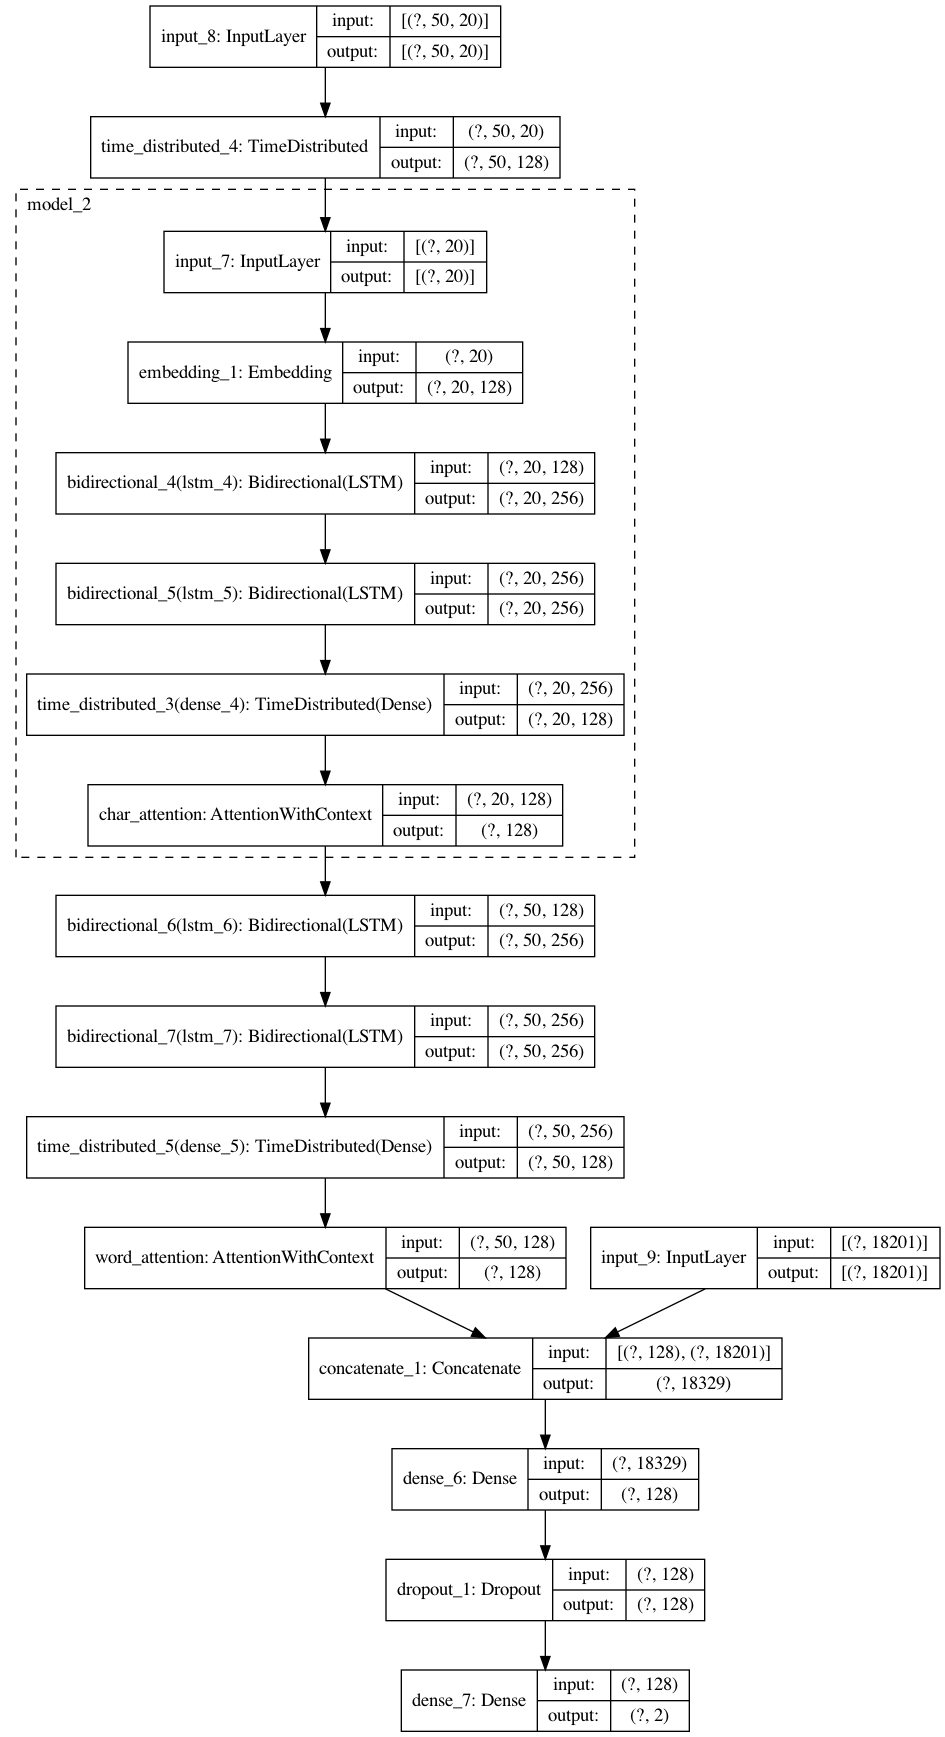

In [36]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [31]:
if os.path.exists(os.path.join(args.model_save_path,'results.csv')):
  results = pd.read_csv(os.path.join(args.model_save_path,'results.csv'))
  index = results.shape[0]
  print (results)
else:
  results = pd.DataFrame(columns=['config','weighted_f1','macro_f1'])
  index = 0

for model_name, model_ in all_models.items():
    
    for loss in ['ce','focal']:
        
        for use_features in [True, False]:
            
            if use_features == False:
                model = model_(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=n_subwords, n_out=n_out,max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=args.max_char_len,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)
            else:
                model = model_(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=n_subwords, n_out=n_out,vectorizer_shape=tfidf_shape, max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=args.max_char_len,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)
            
            if use_features == True:
                print ("Running {} with features for {} loss".format(model_name, loss))
            else:
                print ("Running {} without features for {} loss".format(model_name, loss))

            print (model.summary())

            if loss == 'focal':
                model.compile(loss=models.utils.categorical_focal_loss(alpha=1), optimizer='adam', metrics=['accuracy', models.utils.f1_keras]) #binary_crossentropy
            elif loss == 'ce':
                model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', models.utils.f1_keras]) 

            lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, \
                                                  patience=args.lr_schedule_round, verbose=1, mode='auto', min_lr=0.000001)
            config = {
                  'text_max_len': args.max_text_len,
                  'char_max_len': args.max_char_len,
                  'word_char_max_len': args.max_word_char_len,
                  'n_units': args.n_units,
                  'emb_dim': args.emb_dim,
                  'n_layers': args.n_layers,
                  'epochs': args.epochs,
                  "learning_rate": args.lr,
                  "model_name": model_name,
                  "loss": loss,
                  "use_features": use_features
                }

            if use_features == True:
                model_save_path = os.path.join(args.model_save_path, '{}_{}_with_features.h5'.format(model_name, config['loss']))
            else:
                model_save_path = os.path.join(args.model_save_path, '{}_{}_without_features.h5'.format(model_name, config['loss']))

            f1callback = models.utils.F1Callback(model, [word_val_inputs, char_val_inputs, subword_val_inputs, transformer_val_inputs, val_tfidf],\
                                      val_outputs, \
                                      filename=model_save_path, \
                                      patience=args.early_stopping_rounds)

            K.clear_session()

            if _has_wandb and args.wandb_logging:
                wandb.init(project='hate_speech_detection',config=config)
                model.fit([word_train_inputs, char_train_inputs, subword_train_inputs, transformer_train_inputs, train_tfidf], train_outputs, \
                      validation_data=([word_val_inputs, char_val_inputs, subword_val_inputs, transformer_val_inputs, val_tfidf], val_outputs), \
                          epochs=args.epochs,batch_size=args.train_batch_size, callbacks=[lr, f1callback, WandbCallback()], verbose=2)
            else:
                model.fit([word_train_inputs, char_train_inputs, subword_train_inputs, transformer_train_inputs, train_tfidf], train_outputs, \
                      validation_data=([word_val_inputs, char_val_inputs, subword_val_inputs, transformer_val_inputs, val_tfidf], val_outputs), \
                          epochs=args.epochs,batch_size=args.train_batch_size, callbacks=[lr, f1callback], verbose=2)


            model.load_weights(model_save_path)

            test_pred = model.predict([word_test_inputs, char_test_inputs, subword_test_inputs, transformer_test_inputs, test_tfidf])

            report = classification_report([idx2label[i] for i in test_outputs.argmax(-1)], \
                                           [idx2label[i] for i in test_pred.argmax(-1)])

            f1 = f1_score([idx2label[i] for i in test_outputs.argmax(-1)], \
                                           [idx2label[i] for i in test_pred.argmax(-1)], average='weighted')

            print (report, f1)
            
            results.loc[index,'config'] = str(config)
            results.loc[index, 'weighted_f1'] = f1_score([idx2label[i] for i in test_outputs.argmax(-1)], \
                                           [idx2label[i] for i in test_pred.argmax(-1)], average='weighted')
            results.loc[index, 'macro_f1'] = f1_score([idx2label[i] for i in test_outputs.argmax(-1)], \
                                           [idx2label[i] for i in test_pred.argmax(-1)], average='macro')
            
            index += 1
            
            results.to_csv(os.path.join(args.model_save_path,'results.csv'),index=False)

                                                                                                                                                                                                                                    config  \
0  {'text_max_len': 50, 'char_max_len': 200, 'word_char_max_len': 20, 'n_units': 128, 'emb_dim': 128, 'n_layers': 2, 'epochs': 500, 'learning_rate': 0.001, 'model_name': 'CS_ELMO_without_words', 'loss': 'ce', 'use_features': False}      
1  {'text_max_len': 50, 'char_max_len': 200, 'word_char_max_len': 20, 'n_units': 128, 'emb_dim': 128, 'n_layers': 2, 'epochs': 500, 'learning_rate': 0.001, 'model_name': 'CS_ELMO_without_words', 'loss': 'focal', 'use_features': False}   

   weighted_f1  macro_f1  
0  0.812549     0.770955  
1  0.913472     0.899086  
Running Transformer with features for ce loss
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape

Epoch 20/500

Score 0.9130803146883375. Model not saved.
458/458 - 51s - loss: 0.0084 - accuracy: 0.9989 - f1_keras: 0.9812 - val_loss: 0.3778 - val_accuracy: 0.9278 - val_f1_keras: 0.8304 - lr: 0.0010
Epoch 21/500

Score 0.9082081800600277. Model not saved.
458/458 - 51s - loss: 0.0040 - accuracy: 0.9992 - f1_keras: 0.9914 - val_loss: 0.3871 - val_accuracy: 0.9234 - val_f1_keras: 0.8276 - lr: 0.0010
Epoch 22/500

Score 0.9155307056051013. Model not saved.
458/458 - 51s - loss: 0.0059 - accuracy: 0.9992 - f1_keras: 0.9816 - val_loss: 0.3823 - val_accuracy: 0.9300 - val_f1_keras: 0.8345 - lr: 0.0010
Epoch 23/500

Score 0.9074090153922744. Model not saved.
458/458 - 51s - loss: 0.0067 - accuracy: 0.9992 - f1_keras: 0.9871 - val_loss: 0.3596 - val_accuracy: 0.9234 - val_f1_keras: 0.8280 - lr: 0.0010
Epoch 24/500

Score 0.9069977032880774. Model not saved.
458/458 - 51s - loss: 0.0129 - accuracy: 0.9989 - f1_keras: 0.9841 - val_loss: 0.3976 - val_accuracy: 0.9234 - val_f1_keras: 0.8280 - l

Epoch 1/500

Score 0.41857506361323155. Model saved in ../models/hate_detection/Transformer_ce_without_features.h5.
458/458 - 50s - loss: 0.7627 - accuracy: 0.6031 - f1_keras: 0.4836 - val_loss: 0.5163 - val_accuracy: 0.7199 - val_f1_keras: 0.4125 - lr: 0.0010
Epoch 2/500

Score 0.7545799307958476. Model saved in ../models/hate_detection/Transformer_ce_without_features.h5.
458/458 - 46s - loss: 0.6440 - accuracy: 0.6599 - f1_keras: 0.5497 - val_loss: 0.4751 - val_accuracy: 0.7877 - val_f1_keras: 0.6666 - lr: 0.0010
Epoch 3/500

Score 0.7837842148070575. Model saved in ../models/hate_detection/Transformer_ce_without_features.h5.
458/458 - 46s - loss: 0.5402 - accuracy: 0.7499 - f1_keras: 0.6783 - val_loss: 0.4858 - val_accuracy: 0.8053 - val_f1_keras: 0.6979 - lr: 0.0010
Epoch 4/500

Score 0.8121725740814709. Model saved in ../models/hate_detection/Transformer_ce_without_features.h5.
458/458 - 46s - loss: 0.4465 - accuracy: 0.8190 - f1_keras: 0.7684 - val_loss: 0.4186 - val_accuracy: 0.

Epoch 39/500

Score 0.9158960202438463. Model not saved.
458/458 - 46s - loss: 0.0487 - accuracy: 0.9863 - f1_keras: 0.9743 - val_loss: 0.3385 - val_accuracy: 0.9300 - val_f1_keras: 0.8285 - lr: 0.0010
Epoch 40/500

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.

Score 0.9106395215090868. Model not saved.
458/458 - 46s - loss: 0.0144 - accuracy: 0.9954 - f1_keras: 0.9814 - val_loss: 0.5380 - val_accuracy: 0.9256 - val_f1_keras: 0.8256 - lr: 0.0010
Epoch 41/500

Score 0.9236160341200542. Model saved in ../models/hate_detection/Transformer_ce_without_features.h5.
458/458 - 46s - loss: 0.0113 - accuracy: 0.9981 - f1_keras: 0.9827 - val_loss: 0.5678 - val_accuracy: 0.9365 - val_f1_keras: 0.8352 - lr: 7.0000e-04
Epoch 42/500

Score 0.9211525189786058. Model not saved.
458/458 - 46s - loss: 0.0071 - accuracy: 0.9986 - f1_keras: 0.9822 - val_loss: 0.7389 - val_accuracy: 0.9344 - val_f1_keras: 0.8330 - lr: 7.0000e-04
Epoch 43/500

Score 0.9179908422045859. Mode

Epoch 78/500

Score 0.8981502117227547. Model not saved.
458/458 - 46s - loss: 0.0048 - accuracy: 0.9989 - f1_keras: 0.9889 - val_loss: 0.8894 - val_accuracy: 0.9147 - val_f1_keras: 0.8131 - lr: 4.9000e-04
Epoch 79/500

Score 0.8948700253048079. Model not saved.
458/458 - 46s - loss: 0.0037 - accuracy: 0.9989 - f1_keras: 0.9868 - val_loss: 0.9605 - val_accuracy: 0.9125 - val_f1_keras: 0.8110 - lr: 4.9000e-04
Epoch 80/500

Score 0.8948700253048079. Model not saved.
458/458 - 46s - loss: 0.0034 - accuracy: 0.9989 - f1_keras: 0.9879 - val_loss: 1.0429 - val_accuracy: 0.9125 - val_f1_keras: 0.8110 - lr: 4.9000e-04
Epoch 81/500

Score 0.8948700253048079. Model not saved.
458/458 - 47s - loss: 0.0039 - accuracy: 0.9986 - f1_keras: 0.9908 - val_loss: 1.0772 - val_accuracy: 0.9125 - val_f1_keras: 0.8110 - lr: 4.9000e-04
Epoch 82/500

Score 0.8953179402602163. Model not saved.
458/458 - 46s - loss: 0.0042 - accuracy: 0.9989 - f1_keras: 0.9899 - val_loss: 0.7873 - val_accuracy: 0.9125 - val_f1_k

KeyboardInterrupt: 

In [ ]:
results

In [ ]:
results.to_csv(os.path.join(args.model_save_path,'results.csv'),index=False)